In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 1-Load Data

In [2]:
df=pd.read_csv("datasets/zoo.csv").drop(columns=["animal_name"])
df["class"]=df["class"].map({1:"mammal",2:"bird",3:"reptile",4:"fish",5:"amphibian",6:"bug",7:"invertebratede"})
df_train=df.iloc[:df.shape[0]*75//100,:].reset_index(drop=True)
df_test=df.iloc[df.shape[0]*75//100:,:].reset_index(drop=True)
df_train

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,nº_legs,tail,domestic,catsize,class
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,mammal
155,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,0,mammal
156,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,0,mammal
157,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,0,mammal


#### 2-Create Calssification Tree Given Dataset and Minimum Samples per Leaf

In [6]:
class Node:
    def __init__(self,feature_name=None,left=None,right=None,gini=None,threshold=None,binary=None,class_name=None):
        self.feature_name=feature_name
        self.class_name=class_name
        self.left=left
        self.right=right
        self.gini=gini
        self.threshold=threshold
        self.binary=binary

    def predict_class(self,sample):
        if self.feature_name==None:
            return self.class_name
        else:
            if sample[self.feature_name]>self.threshold:
                return self.left.predict_class(sample)
            else:
                return self.right.predict_class(sample)

    def test(self,test_data,target_name):
        accuracy=0
        for i,sample in test_data.iterrows():
            accuracy+=self.predict_class(sample)==sample[target_name]
        accuracy/=len(test_data)
        return accuracy 

    def display(self,nodeInfo=None, inverted=False, isTop=True):
        import functools as fn
        feature_name,class_name, leftNode, rightNode,threshold,binary = nodeInfo(self)
        stringValue=feature_name if feature_name!=None else class_name
        stringValue=str(stringValue)
        if not binary and feature_name:
            stringValue+=">"+str(threshold)
        stringValueWidth  = len(stringValue)
        leftTextBlock     = [] if not leftNode else leftNode.display(nodeInfo,inverted,False)
        rightTextBlock    = [] if not rightNode else rightNode.display(nodeInfo,inverted,False)
        commonLines       = min(len(leftTextBlock),len(rightTextBlock))
        subLevelLines     = max(len(rightTextBlock),len(leftTextBlock))
        leftSubLines      = leftTextBlock  + [""] *  (subLevelLines - len(leftTextBlock))
        rightSubLines     = rightTextBlock + [""] *  (subLevelLines - len(rightTextBlock))
        leftLineWidths    = [ len(line) for line in leftSubLines  ]                            
        rightLineIndents  = [ len(line)-len(line.lstrip(" ")) for line in rightSubLines ]
        firstLeftWidth    = (leftLineWidths   + [0])[0]  
        firstRightIndent  = (rightLineIndents + [0])[0] 
        linkSpacing       = min(stringValueWidth, 2 - stringValueWidth % 2)
        leftLinkBar       = 1 if leftNode  else 0
        rightLinkBar      = 1 if rightNode else 0
        minLinkWidth      = leftLinkBar + linkSpacing + rightLinkBar
        valueOffset       = (stringValueWidth - linkSpacing) // 2  
        minSpacing        = 2
        rightNodePosition = fn.reduce(lambda r,i: max(r,i[0] + minSpacing + firstRightIndent - i[1]), \
                                        zip(leftLineWidths,rightLineIndents[0:commonLines]), \
                                        firstLeftWidth + minLinkWidth)
        linkExtraWidth    = max(0, rightNodePosition - firstLeftWidth - minLinkWidth )
        rightLinkExtra    = linkExtraWidth // 2
        leftLinkExtra     = linkExtraWidth - rightLinkExtra
        valueIndent       = max(0, firstLeftWidth + leftLinkExtra + leftLinkBar - valueOffset)
        valueLine         = " " * max(0,valueIndent) + stringValue
        slash             = "\\" if inverted else  "/"
        backslash         = "/" if inverted else  "\\"
        uLine             = "¯" if inverted else  "_"
        leftLink          = "" if not leftNode else ( " " * firstLeftWidth + uLine * leftLinkExtra + slash)
        rightLinkOffset   = linkSpacing + valueOffset * (1 - leftLinkBar)                      
        rightLink         = "" if not rightNode else ( " " * rightLinkOffset + backslash + uLine * rightLinkExtra )                                                                                                
        linkLine          = leftLink + rightLink                                        
        leftIndentWidth   = max(0,firstRightIndent - rightNodePosition) 
        leftIndent        = " " * leftIndentWidth
        indentedLeftLines = [ (leftIndent if line else "") + line for line in leftSubLines ]
        mergeOffsets      = [ len(line) for line in indentedLeftLines ]
        mergeOffsets      = [ leftIndentWidth + rightNodePosition - firstRightIndent - w for w in mergeOffsets ]
        mergeOffsets      = [ p if rightSubLines[i] else 0 for i,p in enumerate(mergeOffsets) ]
        mergedSubLines    = zip(range(len(mergeOffsets)), mergeOffsets, indentedLeftLines)
        mergedSubLines    = [ (i,p,line + (" " * max(0,p)) )       for i,p,line in mergedSubLines ]
        mergedSubLines    = [ line + rightSubLines[i][max(0,-p):]  for i,p,line in mergedSubLines ]                        
        treeLines = [leftIndent + valueLine] + ( [] if not linkLine else [leftIndent + linkLine] ) + mergedSubLines
        treeLines = reversed(treeLines) if inverted and isTop else treeLines
        if isTop : print("\n".join(treeLines))
        else     : return treeLines      

def create_node_from_feature(feature_name,target_name,dataset):
    means=[]
    continuous_values=sorted(dataset[feature_name].unique())
    step=1
    for i in range(0,len(continuous_values)-step,step):
        means.append(continuous_values[i]*0.5+continuous_values[i+step]*0.5)
    if len(means)==0:
        return Node(gini=1)
    best_node={}
    best_gini=1
    for threshold in means:
        left,right={},{}
        feature_index=dataset.columns.get_loc(feature_name)
        target_index=dataset.columns.get_loc(target_name)
        for sample in dataset.to_numpy():
            feature_value=sample[feature_index]
            target_class=sample[target_index]
            if feature_value>threshold:
                if target_class in left:
                    left[target_class]+=1
                else:
                    left[target_class]=1
            else:
                if target_class in right:
                    right[target_class]+=1
                else:
                    right[target_class]=1
        gini=gini_impurity([left,right])
        if gini<best_gini:
            best_gini=gini
            best_node=Node(feature_name,left,right,gini,threshold,feature_types[feature_name])
    return best_node

def gini_impurity(node_predictions):
    gini=0
    total_n=0
    for p in node_predictions:
        n=sum(p.values())
        ps=(np.array(list(p.values()))/n)**2
        gini+=n*(1-sum(ps))
        total_n+=n
    return gini/total_n

def best_node(dataset,target_name):
    best_gini=1
    best_node={}
    for feature in dataset:
        if feature!=target_name:
            node=create_node_from_feature(feature,target_name,dataset)
            if node.gini<best_gini:
                best_gini=node.gini
                best_node=node
    return best_node

def classification_tree(dataset,target_name,min_samples=25):
    #If leaf is pure
    if len(dataset[target_name].unique())==1:
        return Node(class_name=list(dataset[target_name])[0])
    #Reach minimun samples per leaf
    elif 0<len(dataset)<min_samples:
        return Node(class_name=dataset[target_name].value_counts().idxmax())
    #Each feature has just one value
    elif max(dataset.drop(columns=[target_name]).apply(lambda col:len(col.unique())))==1:
        return Node(class_name=dataset[target_name].value_counts().idxmax())
    #No more attributes or samples
    elif len(dataset)==0 or len(dataset.columns)==1:
        return None
    else:
        node=best_node(dataset,target_name)
        if feature_types[node.feature_name]:
            next_left=dataset[dataset[node.feature_name]>node.threshold].drop(columns=[node.feature_name])
            next_right=dataset[dataset[node.feature_name]<=node.threshold].drop(columns=[node.feature_name])
        else:
            next_left=dataset[dataset[node.feature_name]>node.threshold]
            next_right=dataset[dataset[node.feature_name]<=node.threshold]
        node.left=classification_tree(next_left,target_name,min_samples)
        node.right=classification_tree(next_right,target_name,min_samples)
        if node.left.feature_name == None:
            if node.left.class_name==node.right.class_name:
                node=Node(class_name=node.left.class_name)
        return node
         
feature_types={f_name:len(df_train[f_name].unique())==2 for f_name in df_train}
tree=classification_tree(df_train,"class",25)
tree.display(lambda n:(n.feature_name,n.class_name,n.left,n.right,n.threshold,n.binary))
print("\nAccuracy : ",tree.test(df_train,"class"))

      milk
      /  \
mammal    feathers
            /  \
        bird    fins
                /  \
            fish    backbone
                 _____/  \_____
             tail              nº_legs>5.5
             /  \                  / \
      reptile    amphibian  aquatic   invertebratede
                              / \
                invertebratede   bug

Accuracy :  0.9629629629629629


#### 3-K-Fold Cross Validation to Find Optimal Parameter: Minimum Samples per Leaf

Mejor valor:  25 0.9303571428571429


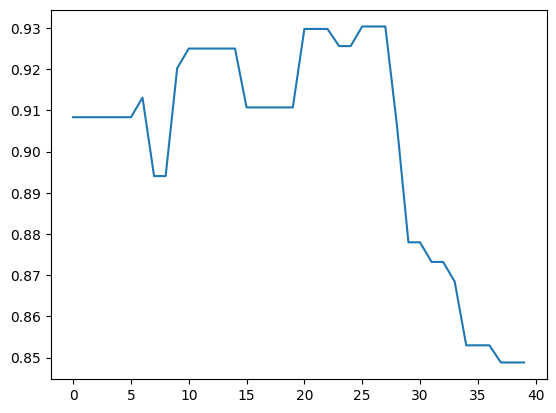

In [4]:
#30 s
k=10
accuracy_averages=[]
for m in range(40):
    indxs=[ind for ind in range(0,len(df)-len(df)//k,len(df)//k)]+[len(df)]
    acc=0
    for i in range(len(indxs)-1):
        df_test=df.iloc[indxs[i]:indxs[i+1],:]
        df_train=pd.concat([df.iloc[0:indxs[i],:],df.iloc[indxs[i+1]:,:]])
        tree = classification_tree(df_train,"class",m)
        acc+=tree.test(df_test,"class")
    accuracy_averages.append(acc/(len(indxs)-1))
plt.plot(range(40),accuracy_averages)
print("Mejor valor: ",accuracy_averages.index(max(accuracy_averages)),max(accuracy_averages))